# Algorithm Benchmarking with QASM Simulations

The purpose of this notebook is to evaluate the performance of the implemented quantum time evolution algorithm. The common evaluated criteria are circuit depth and state fidelity. For QASM simulations, the metrics to be evaluated are

> 1. **Circuit depth**
> 1. **Trace distance**

In this notebooks, data is generated using Qiskit, and analyzed to find an expected relation between _evolution time_, _expected fidelity_ and _number of integration steps_. So first, It is wise to start with a little summary about the general results of quantum time evolution as presented by [1], then proceed to demonstrate how to use the devised routines for simulating a generic spin graph, and finally, produce some plots that show the actual performance of the programmed algorithm.

## General Quantum Time Simulation Theory

In this project, a second order Trotter scheme is proposed to estimate evolution of a spin system. Consider a Hamiltonian that can be written as the sum of _local Hamiltonians_ (acting on a small subsystem at a time).

$$
\hat{H} = \sum_{i=1}^{l} \hat{H}_i
$$

By direct computation, it is possible to show that

$$
\mathrm{e}^{-\mathrm{i}t\hat{H}} = \prod_{i=1}^{l} \mathrm{e}^{-\mathrm{i}t\hat{H}_i} + \mathcal{O}(t^2)
$$

Now, if evolution is carried out over a small enough period of time, then the difference between the right hand side and the left hand side is small. This leads to an integration scheme that relies on the implementation of local evolution operators, that is capable of simulate complex correlation in a quantum system, as long as it arises from small-subsystem interactions.

### Efficiency of Quantum Time Simulation Algorithms

Berry et. atl. [1] have already considered the general error theory of Suzuki-Trotter schemes, and te minimal amount of resources required to simulate a quantum system. First, let's discuss the expected number of operations required to obtain a desired error bound, for a given simulation time, and then, the minimal amount of resources required to simulate a given quantum system.

In their paper, Berry et. al. demonstrate that the expected number of steps (as measured by the number of exponentials required to implement a $k$-th order Suzuki-Trotter scheme) is bounded by a power law

$$
N \leq A_k \frac{t^{1+1/2k}}{\epsilon^{1/2k}}
$$

It is interesting, as they point out, that there is an optimal order for the integration scheme. However, the main takeaway here, at least by now, is that

> There exists a power law that relates the number of steps, integration time and error bound, or a given quantum system.

And so, this is what will be sought when benchmarking the proposed algorithm.

Finally, Berry et. al. point out that any Hamiltonian (at least of practical interest) may be simulated by a quantum algorithm using at least a linear amount of steps. Now, the remarkable part, at least for the purpose of this project is that

> If a simulation algorithm uses an amount of steps that scales linearly with time for given precision, then it is almost optimal. At least within a constant factor that can be optimized.

## Structure of the Notebook

This notebook is structured as follows. First, results obtained by Salathé et. al. and Las Heras et. al. are reproduced to show the correctness of the algorithms proposed. Simulations are carried out on `ibmq_quito`, and measurement error mitigation is implemented as well. After that, average quantum process fidelities of time evolution, over the model parameters, are computed for a system of 4 qubits. Simulations are carried out using `qasm_simulator` to assess the fault-tolerant limitations of the evolution algorithms proposed. Finally, quantum process fidelities are computed using a noisy model of `ibmq_quito` and QASM simulators, to assess the NISQ limitations of this algorithms.

Let's start by importing the necessary packages

In [1]:
from PyHeisenberg import HeisenbergGraph, DataAnalyzer, NaiveSpinGraph
import numpy as np
import matplotlib.pyplot as plt
import warnings
from operator import itemgetter
warnings.filterwarnings('ignore')
plt.style.use('FigureStyle.mplstyle')

## Reproduction of results obtained by Salathé et. al.

In this section, a two-spin isotropic Heisenberg model is simulated using the networks proposed in the main document. This Hamiltonian corresponds to

$$
\hat{H} = J(\hat{X}_1\hat{X}_2 + \hat{Y}_1\hat{Y}_2 + \hat{Z}_1\hat{Z}_2)
$$

Following the group's work, the initial state

$$
|\psi_0\rangle = |+\rangle\otimes|0\rangle
$$

Is evolved for a time $t=3 \pi /4$, when $J = 1$. Time series of the expected values of single-qubit Pauli operators are generated and compared to results obtained by direct diagonalization of the Hamiltonian. The time interval is partitioned on $12$ equally spaced intervals.

### Definition of the Graph Object

As mentioned on the main text, the Hamiltonian gives rise to a graph that is used to store the information of the spin-spin and field-spin interactions. More parameters such as the execution backend, initial state and noise activation are included as well.

In [2]:
testGraph = HeisenbergGraph(
    spinInteractions={
        (0, 1): [1, 1, 1],
    },
    externalField={
        0: [0.0, 0.0, 0.0],
        1: [0.0, 0.0, 0.0],
    },
    localSimulation=False,
    backendName='ibmq_bogota',
    noisySimulation=False,
    initialState=1/np.sqrt(2) * np.array([1, 0, 1, 0])
)
testAnalyzer = DataAnalyzer(spinGraph=testGraph)

### Computation of Exact Evolution Time Series

These correspond to direct diagonalization using Numpy. By default, 200 steps are used for producing a somewhat smooth theoretical curve of the evolution of expected values of a Pauli string operator.

In [3]:
pauliStrings = ['XI', 'IX', 'YI', 'IY', 'ZI', 'IZ']
timesEx, resultSeriesExact = testGraph.exactPauliExpValSeries(
    pauliStrings,
    t = 3*np.pi/4
)
ExX1, ExX2, ExY1, ExY2, ExZ1, ExZ2 = itemgetter(*pauliStrings)(resultSeriesExact)

### Computation of Experimental Evolution Time Series

These correspond to quantum time simulation using algorithms descried on the main text. By default, 200 steps are used for producing a somewhat smooth experimental curve of the evolution of expected values of a Pauli string operator. Due to decoherence and gate errors, it is suggested that no more than 20 steps for simulating time evolution on real quantum devices.

To mitigate readout errors, a special technique is used. It uses a markovian model for correcting possible bit filp errors on readout. It is implemented on this notebook using `qiskit.ignis`.

#### Measurement error mitigation

To apply measurement error mitigation, generate a sequence of quantum circuits to measure the readout errors when preparing states of the computational basis. Then fit an evolution matrix for assessing the transition probabilities, and define a filter for correction results of future algorithm's execution. This is done by `qiskit.ignis`.

In [ ]:
measurementFitter = testGraph.getCalibrationFitter()

#### Computation of Time Series on IBM Quantum

Due to current limitations of cloud-based quantum computing, the `HeisenbergGraph` class optimizes the process of running quantum circuits on real quantum deices. It is recommended that the following routine be used for computing time series of expected value of Pauli string observables. The function returns `ndarray`s, which can be linearly combined to compute time series of generic quantum operators.

In [15]:
times, resultSeries = testGraph.pauliExpValSeries(
    pauliStrings,
    MAX_STEPS = 12,
    t = 3*np.pi/4,
    measurementFitter= measurementFitter
)
X1, X2, Y1, Y2, Z1, Z2 = itemgetter(*pauliStrings)(resultSeries)

Job Status: job has successfully run


What follows is to plot the experimental results. A comparative plot of theoretical values an experimental values is presented on this cell. Since time evolution of this system is exact, the experimental points (scatter plots) resemble quite well the theoretical curves (dashed lines). Red datasets corresponds to the second spin's observables, whereas the blu datasets corresponds to the first spin's observables.

**Important:** During simulations, the specifications of the QPU were

|$T_1$|$T_2$|CNOT err.|Readout err.|
|:-:|:-:|:-:|:-:|
|103.34 us|124.79 us|1.931e-2|3.070e-2|

Measurement error mitigation is optional. However, it is highly recommended. Since `Qiskit Runtime` is still on beta, this project doesn't rely on that architecture.

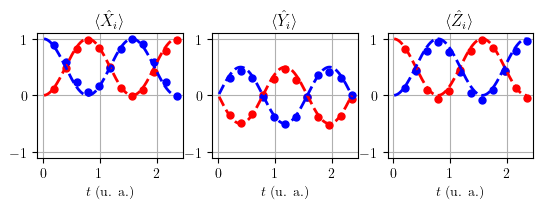

In [16]:
fig, (axX, axY, axZ) = plt.subplots(1,3)
axX.plot(times, X1, 'ro', times, X2, 'bo')
axX.plot(timesEx, ExX1, color='red', linewidth=2, linestyle='dashed')
axX.plot(timesEx, ExX2, color='blue', linewidth=2, linestyle='dashed')
axX.set_title(r"$\langle\hat{X}_i\rangle$")
axX.set_xlabel(r"$t$ (u. a.)")
axX.set_aspect('equal')
axX.set_ylim([-1.1, 1.1])
axY.plot(times, Y1, 'ro', times, Y2, 'bo')
axY.plot(timesEx, ExY1, color='red', linewidth=2, linestyle='dashed')
axY.plot(timesEx, ExY2, color='blue', linewidth=2, linestyle='dashed')
axY.set_title(r"$\langle\hat{Y}_i\rangle$")
axY.set_xlabel(r"$t$ (u. a.)")
axY.set_aspect('equal')
axY.set_ylim([-1.1, 1.1])
axZ.plot(times, Z1, 'ro', times, Z2, 'bo')
axZ.plot(timesEx, ExZ1, color='red', linewidth=2, linestyle='dashed')
axZ.plot(timesEx, ExZ2, color='blue', linewidth=2, linestyle='dashed')
axZ.set_title(r"$\langle\hat{Z}_i\rangle$")
axZ.set_xlabel(r"$t$ (u. a.)")
axZ.set_aspect('equal')
axZ.set_ylim([-1.1, 1.1])
plt.savefig('XYZModel.pdf')
plt.show()


## Reproduction of results of Las Heras et. al. and Salathé et. al.

In this section, the two-spin transverse field Ising model, 

$$
\hat{H} = \frac{V}{2}(\hat{X}_1\hat{X}_2 + \hat{Y}_1\hat{Y}_2 + \hat{Z}_1\hat{Z}_2) + \frac{U}{4}(\hat{Z}_1 + \hat{Z}_2)
$$

with $V = U = 1$, is simulated over a time $\tau = 5$. The initial state is set to

$$
|\psi_0\rangle = |+\rangle\otimes|0\rangle
$$

Simulations are carried out using `ibmq_quito`, and error correction. First, a graph object is instantiated with the desired parameter values ($J=1$). Spin interactions are defined as a dictionary with a tuple key that points the index of the involved sites, and a value that has the interaction parameters as defined on the main document. Filed interactions are described y a dictionary whose key is the site index, and its value is an iterable that has the cartesian components of the local field, as defined on the main text.

A comparative evolution plot is generated using the `dataAnalyzer` object. The number of Trotter steps is taken to be $N = 8$. However, this can be changed at will.

In [ ]:
isingGraph = HeisenbergGraph(
    spinInteractions={
        (0, 1): [0.5, 0.5, 0.5],
    },
    externalField={
        0: [0.0, 0.0, 0.25],
        1: [0.0, 0.0, 0.25],
    },
    localSimulation=False,
    backendName='ibmq_bogota',
    noisySimulation=False,
    initialState=1/np.sqrt(2) * np.array([1, 0, 1, 0])
)
isingAnalyzer = DataAnalyzer(spinGraph=isingGraph)

### Evolution of occupation number

Remember that each computational basis state can be mapped to an integer. This integer is shown on the plot legends. An excited fermionic mode is mapped to the ground state of a qubit $|1\rangle$, and the ground fermionic mode to the excited state of a qubit $|0\rangle$. Simulations were carried out on `ibmq_bogota`. Notice that, in this case, the occupation numbers are not so close to the theoretical values. This is due to many sources of errors. This will be addressed bellow. By now, those are stated

1. Readout error
1. Gate error (CNOT and $\pi/2$-pulses)
1. Qubit relaxation
1. Decoherence nd thermal relaxation

**Important:** During simulations, the specifications of the QPU were

|$T_1$|$T_2$|CNOT err.|Readout err.|
|:-:|:-:|:-:|:-:|
|103.34 us|124.79 us|1.931e-2|3.070e-2|

Job Status: job has successfully run


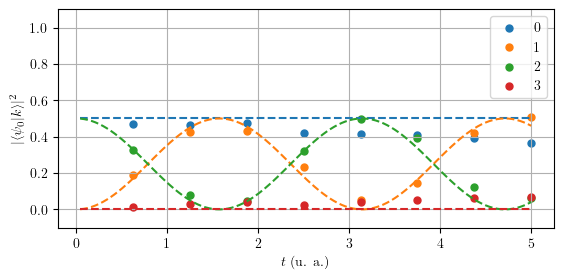

In [20]:
isingAnalyzer.comparativeEvolution(
    STEPS=8, 
    t=5.0,
    measurementFitter=measurementFitter
)
plt.savefig('HubbardTwoMode.pdf')

In [8]:
benchmarkGraph = HeisenbergGraph(
    spinInteractions={
        (0, 1): [0.5, 1.0, 0.25],
        (1, 2): [0.5, 1.0, 0.25],
        (2, 3): [0.5, 1.0, 0.25],
        (3, 4): [0.5, 1.0, 0.25],
    },
    externalField={
        0: [1.0, 0.25, 0.5],
        1: [1.0, 0.25, 0.5],
        2: [1.0, 0.25, 0.5],
        3: [1.0, 0.25, 0.5],
        4: [1.0, 0.25, 0.5],
    },
    localSimulation=True,
    backendName='qasm_simulator',
    noisySimulation=False,
    initialState=np.array([1 if idx == 1 else 0 for idx in range(2**5)])
)
benchmarkAnalyzer = DataAnalyzer(spinGraph=benchmarkGraph)


In [7]:
reps = 1
MAX_STEPS = 36
data = benchmarkAnalyzer.pdfErrorStepsPlot(
    MAX_STEPS=MAX_STEPS,
    times=[1,2,4,8,16,32],
    reps=reps
)
meanData = 1/reps * sum(rep for rep in data)
stdData = np.sqrt(1/reps * sum((rep - meanData)**2 for rep in data))

KeyboardInterrupt: 

In [4]:
infidelities = 1 - meanData

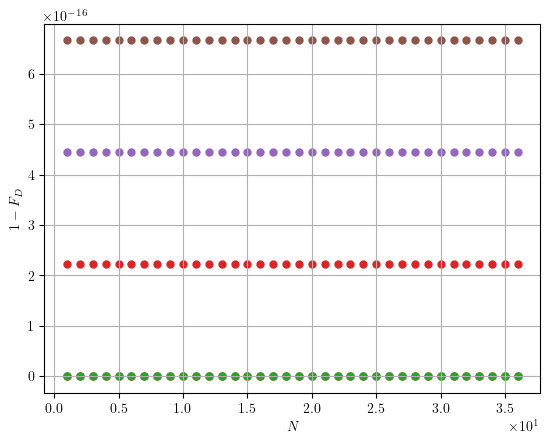

In [5]:
STEPS = [idx for idx in range(1, MAX_STEPS+1)]
for dataset, std in zip(infidelities, stdData):
    plt.scatter(STEPS, dataset)
    # plt.errorbar(STEPS, dataset, yerr=std, fmt="--o", capsize=5)
plt.xlabel(r'$N$')
plt.ylabel(r'$1-F_D$')
plt.show()

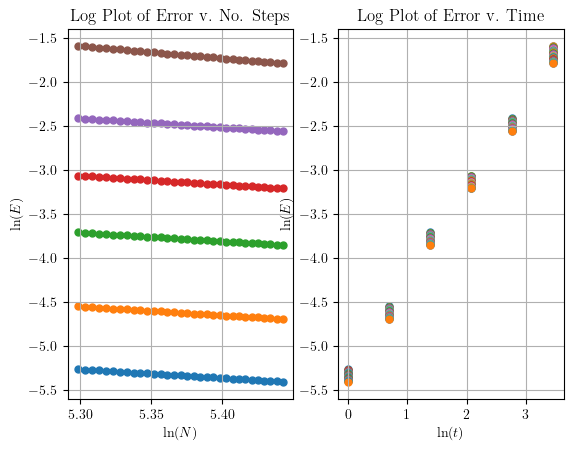

In [26]:
sim = benchmarkAnalyzer.unitaryErrorMixedPlot(
    STEPS = np.array([idx for idx in range(200, 232)]),
    times = [1,2,4,8,16,32]
)

Tested initial states:

1. $|00000\rangle$
1. $\frac{1}{\sqrt{2^2}}|000\rangle(\sum_{i=0}^3 |i\rangle)$
1. $\frac{1}{\sqrt{2^5}}\sum_{i=0}^{31}|i\rangle$
1. $\frac{1}{\sqrt{2^3}}|00\rangle(\sum_{i=0}^{7}|i\rangle)$